(1942420, 17)
[11  0  6  7 19  8  9 10 12 13 14 15 16 17  1  2  3  4  5 18 20 21 22 23]
E    631164
A    566760
M    473142
N    271354
Name: tpep_pickup_hour_slots, dtype: int64
6.89449405670166


<AxesSubplot:title={'center':'Barplot'}>

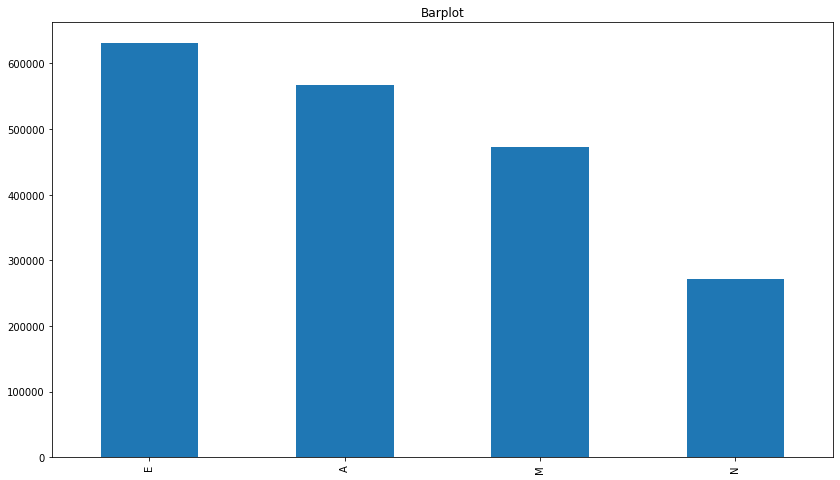

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import time
import matplotlib as plt

# Read both datasets and concatenate. 
start = time.time()
data1 = pd.read_csv("tripdata_2017-01.csv")
data2 = pd.read_csv("tripdata_2017-02.csv")
data = pd.concat([data1,data2])
print(data.shape)

# Change the format of variable to datetime and extract the hour
data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].astype('datetime64[ns]') 
data['tpep_pickup_hour'] = data.tpep_pickup_datetime.dt.hour

# Print unique values
print(data['tpep_pickup_hour'].unique())

# Convert the discrete variable to continuous variable
col         = 'tpep_pickup_hour'
conditions  = [ (data[col] >= 0) & (data[col] < 6), 
                (data[col]>= 6) & (data[col] < 12), 
               (data[col]>= 12) & (data[col] < 18),
               (data[col]>= 18) & (data[col] <= 24) 
  ]
choices     = [ 'N', 'M', 'A', 'E']
    
data["tpep_pickup_hour_slots"] = np.select(conditions, choices, default=np.nan)

# Now there are only four categories which express the time zone
data['tpep_pickup_hour_slots'].unique()

# Relative frequencies
print(data['tpep_pickup_hour_slots'].value_counts())
end = time.time()
print(end-start)

# Barlot of the new variable created
data['tpep_pickup_hour_slots'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Barplot")

In [3]:
# Import libraries 
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import time
from pyspark.ml.feature import StringIndexer

# Create a Spark session. The number of cores selected will be crutial.
spark = SparkSession.builder\
      .master("local[6]")\
      .appName("Study2")\
      .getOrCreate()

start = time.time()
data_sp1 = spark.read.csv('tripdata_2017-01.csv', header = True)
data_sp2 = spark.read.csv('tripdata_2017-02.csv', header = True)
data_sp = data_sp1.union(data_sp2)
print((data_sp.count(), len(data_sp.columns)))


data_sp = data_sp.withColumn("tpep_pickup_timestap",to_timestamp("tpep_pickup_datetime")) 
data_sp = data_sp.withColumn("hour", hour(to_timestamp("tpep_pickup_timestap","yyyy-MM-dd HH:mm:ss")))
data_sp = data_sp.withColumn("slots_hour", when((col("hour") >= 0) & (col("hour") < 6),"N")
                                 .when((col("hour") >= 6) & (col("hour") < 12),"M")
                                 .when((col("hour") >= 12) & (col("hour") < 18),"A")
                                 .when((col("hour") >= 18) & (col("hour") <= 24),"E")
                                 .when(col("hour").isNull() ,""))
                            
data_sp.groupBy('slots_hour').count().show()
data_sp = data_sp.withColumn("slots_hour", data_sp["slots_hour"].cast(IntegerType()))
#data = data_sp.toPandas()
spark.stop()
# Barlot of the new variable created
#data_sp['slots_hour'].value_counts().plot(kind='bar',
                                    #figsize=(14,8),
                                    #title="Barplot")
#end = time.time()


(1942420, 17)
+----------+------+
|slots_hour| count|
+----------+------+
|         E|631164|
|         M|473142|
|         A|566760|
|         N|271354|
+----------+------+



In [99]:
# Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api

gre_histogram = data_sp.select('hour').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar')

AttributeError: 'NoneType' object has no attribute '_jvm'

In [17]:
from pyspark.sql import SparkSession
import pandas as pd 
spark = SparkSession.builder.appName("prueba").master("local[*]").getOrCreate()

#Again, we begin by reading our data. 

data_spark = spark.read.option("header","true").csv("tripdata_2017-01.csv")

#Now, we select the columns corresponding to the amount of money excluding the taxes. 
no_taxes = data['fare_amount'] + data['tip_amount'] + data['tolls_amount'] + data['extra'] + data['improvement_surcharge']

#Since we want the redd to be created from a list, we transform this python series into a list.
no_taxes_list = no_taxes.tolist()
#Let's check that it is indeed a list. 
print(type(no_taxes_list))
#Now, we create the rdd object. 
rdd=spark.sparkContext.parallelize(no_taxes_list)

#Since we want to compute the mean value, we need to compute the sum of all the elements of the object, the count of these elements 
#and divide them. 

#Let's start by computing and printing the number of observations present in the rdd object. 
count = rdd.count()
print(count)
#Secondly, we sum the elements of the rdd thanks to the function .reduce(), which allows us to make computations between the elements
#of a list. 
suma = rdd.reduce(lambda a,b : (a+b))
print(suma)
#Lastly, we divide them and obtain the mean value. 
print(suma/count)

#We can do the same thing for the 'mta_tax' value. 

taxes = data['mta_tax'] 
taxes_list = taxes.tolist()

rdd2 = spark.sparkContext.parallelize(taxes_list)
count2 = rdd2.count()
suma2 = rdd2.reduce(lambda a,b : a+b)

mean = suma2/count2
print(mean)

<class 'list'>
1942420
29823363.75990732
15.353715344728391
0.4974637874404094
